# 4 CNN: Batch Normalizatoin
<p>We'll implement a Convolutional Neural network (CNN) with Batch Normalization.</p>

<ul>
    <li><a href="#data">Data</a></li>
    <li><a href="#model">Model</a></li>
    <li><a href="#training">Training</a></li>
    <li><a href="#results">Results</a></li>
</ul>

In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
# Helper functions

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## <a name="data" id="data">Data</a>

In [3]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [4]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [10]:
# Show the data type for each element in dataset - long
type(train_dataset[0][1])
# Each element in the rectangular tensor corresponds to a number 
# representing a pixel intensity as demonstrated by the following image.

int

label: 5


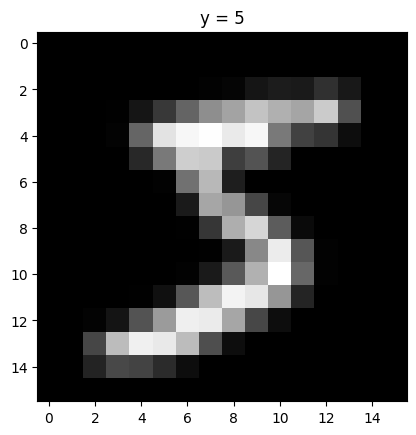

In [5]:
print("label: "+ str(train_dataset[0][1]))
show_data(train_dataset[0])

## <a name="model" id="model">Model</a>

In [6]:
# Build a Convolutional Network class with two Convolutional layers 
# and one fully connected layer. 
# Pre-determine the size of the final output matrix. 
# The parameters in the constructor are the number of output channels for the 
# first and second layer.

class CNN(nn.Module):
    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [7]:
# CNN Class with 2 Convolutional layers, and
# one fully connected layer.
# Add Batch Normalization for the convolutional layers

class CNN_batch(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [9]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

In [10]:
model

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

## <a name="training" id="training">Training</a>

In [ ]:
# Train the model

def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    N_test = len(validation_dataset)
    accuracy_list = []
    loss_list = []
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [12]:
# Train the model
accuracy_list_normal, loss_list_normal = train_model(
    model=model,
    n_epochs=10,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer
)

### Train: Batch Normalization

In [13]:
model_batch = CNN_batch(out_1=16, out_2=32)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)

accuracy_list_batch, loss_list_batch = train_model(
    model=model_batch,
    n_epochs=10,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer
)

## <a name="results" id="results">Results</a>

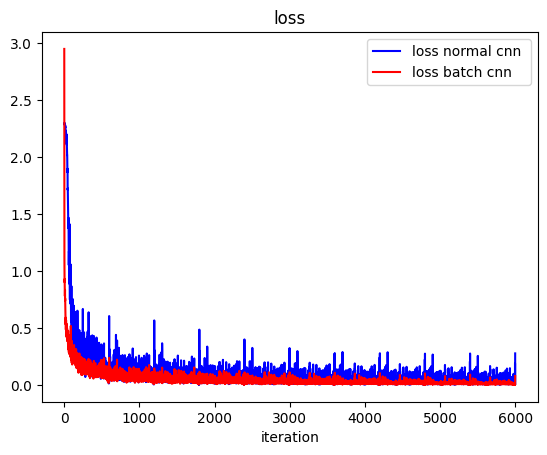

In [14]:
# Plot the loss
plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

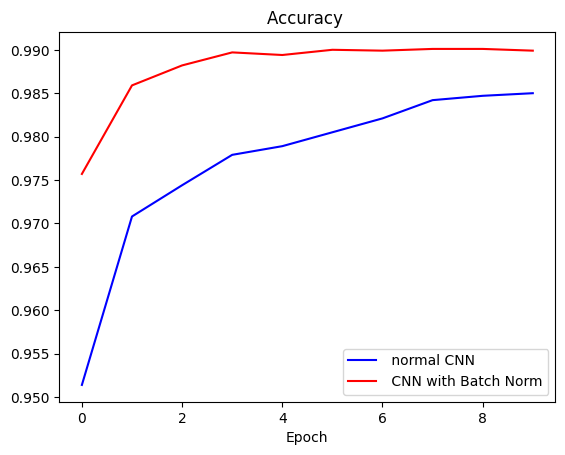

In [15]:
# Plot accuracy
plt.plot(accuracy_list_normal, 'b',label=' normal CNN')
plt.plot(accuracy_list_batch,'r',label=' CNN with Batch Norm')
plt.xlabel('Epoch')
plt.title("Accuracy ")
plt.legend()
plt.show()

### Inspect activations

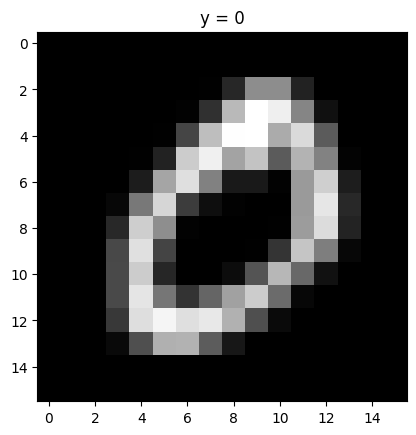

In [28]:
# Show the second image
show_data(train_dataset[1])

In [29]:
# Use the CNN activations class to see the steps
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

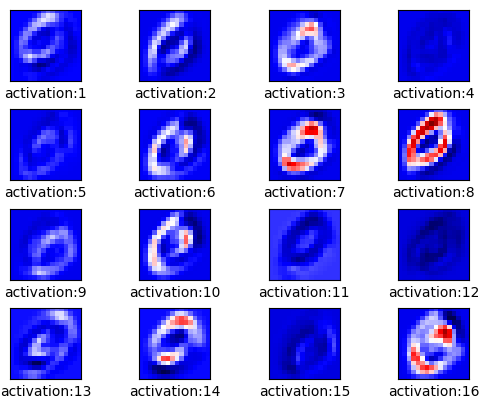

In [30]:
# Plot the outputs after the first CNN
plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

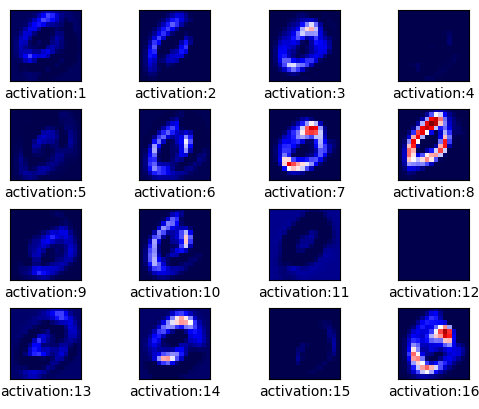

In [31]:
# Plot the outputs after the first Relu
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

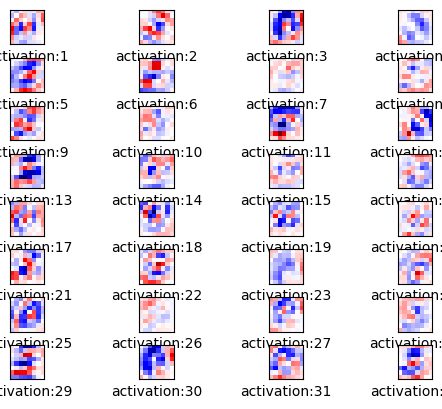

In [32]:
# Plot the outputs after the second CNN
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

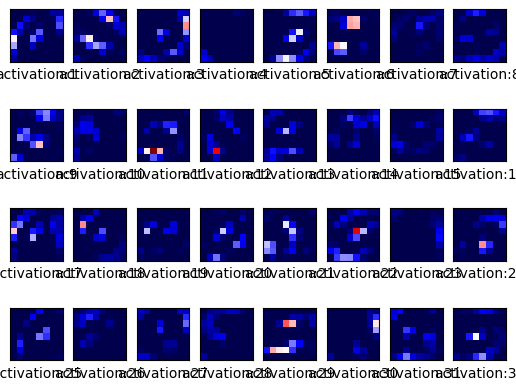

In [33]:
# Plot the outputs after the second Relu
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

### Misclassified samples

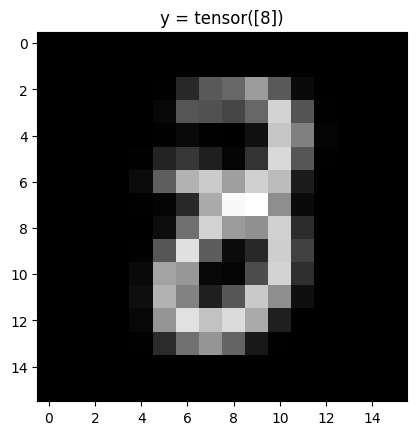

y_hat:  tensor([3])


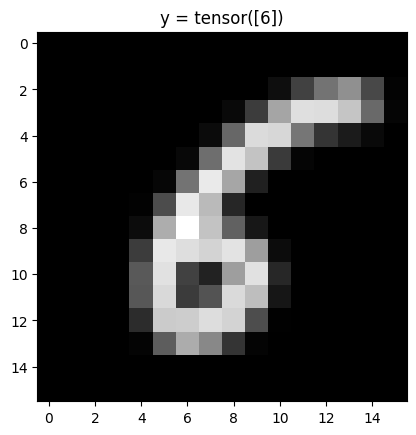

y_hat:  tensor([5])


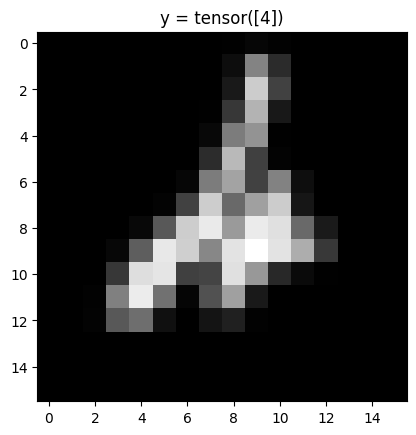

y_hat:  tensor([2])


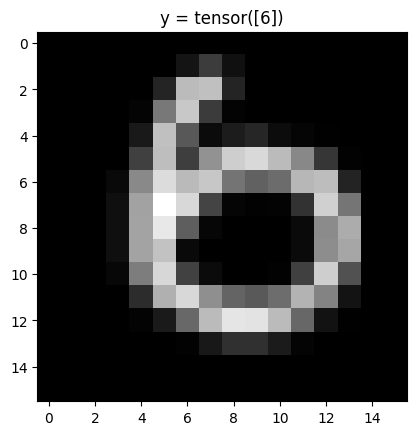

y_hat:  tensor([0])


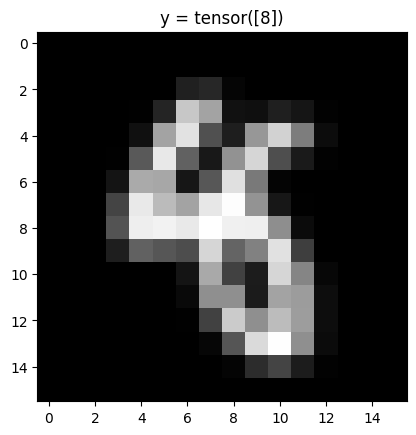

y_hat:  tensor([4])


In [39]:
# Plot the misclassified samples
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, y_hat = torch.max(z, 1)
    if y_hat != y:
        show_data((x, y))
        plt.show()
        print("y_hat: ",y_hat)
        count += 1
    if count >= 5:
        break  